# Objective

- This script builds a handwritten text recognition model using [PyLaia](https://github.com/jpuigcerver/PyLaia) on Dutch data from the 18th Century collected during the *getuigenissen project* https://www.getuigenissen.org
- In order to do this, images taken from that website as well as the transcribed texts. The images were split into image lines and the transcribe text of the line was aligned with it. This is our training data which we had locally on Google Drive

# Get our data

- images segmented in text lines

In [2]:
%cd /content
!rm -r getuigenissen
!mkdir getuigenissen
!mkdir getuigenissen/train
!mkdir getuigenissen/log
!mkdir getuigenissen/imgs

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
!cp /content/drive/My\ Drive/imgs.zip /content/getuigenissen

# Install PyLaia

- Running on Google Colab
- Pylaia requires imgtxtenh, imagemagick to be in the path
- As well requires Pytorch 1.5 but Google Colab version of CUDA seems incompatible with nnutils which is a dependency of PyLaia which is next incompatible with the version of the NVIDIA driver on Colab (issue reported at https://github.com/jpuigcerver/PyLaia/issues/26)
- Solution to this: install Python 3.8 and use Pytorch 1.6 alongside PyLaia

In [9]:
!Rscript -e "Sys.getenv()"

__EGL_VENDOR_LIBRARY_DIRS
                        /usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/
_R_CHECK_COMPILATION_FLAGS_KNOWN_
                        -Wformat -Werror=format-security -Wdate-time
CLICOLOR                1
CLOUDSDK_CONFIG         /content/.config
CLOUDSDK_PYTHON         python3
COLAB_GPU               1
CUDA_PKG_VERSION        10-1=10.1.243-1
CUDA_VERSION            10.1.243
CUDNN_VERSION           7.6.5.32
DATALAB_SETTINGS_OVERRIDES
                        {"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\"172.28.0.2\""]}
DEBIAN_FRONTEND         noninteractive
EDITOR                  vi
ENV                     /root/.bashrc
GCE_METADATA_TIMEOUT    0
GCS_READ_CACHE_BLOCK_SIZE_MB
                        16
GIT_PAGER               cat
GLIBCPP_FORCE_NEW       1
GLIBCXX_FORCE_NEW       1
HOME                    /root
HOSTNAME                d77daa36eeef
JPY_PARENT_PID          24
LANG                    en_US.UTF-8
LAST_FORCED_

In [10]:
%cd /content
!cat /etc/os-release
!env
!uname -m 
!uname -r
!cat /proc/driver/nvidia/version 
!which nvcc
!nvcc --version
!which nvidia-smi
!nvidia-smi

/content
NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
CUDNN_VERSION=7.6.5.32
__EGL_VENDOR_LIBRARY_DIRS=/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/
LD_LIBRARY_PATH=/usr/lib64-nvidia
CLOUDSDK_PYTHON=python3
_=/usr/bin/env
LANG=en_US.UTF-8
HOSTNAME=d77daa36eeef
OLDPWD=/
CLOUDSDK_CONFIG=/content/.config
NVIDIA_VISIBLE_DEVICES=all
DATALAB_SETTINGS_OVERRIDES={"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\"172.28.0.2\""]}
ENV=/root/.bashrc
PAGER=cat
NCCL_VERSION=2.4.8
TF_FORCE_GPU_ALLOW_GROWTH=true
JPY_PARENT_PID=24
NO_GCE_CHECK=True
PWD=/content
HOME=/root
LAST_FORCED_REBUILD=20200729
CLICOLOR=1
DEBIAN_FRONTE

CUDA runtime apparently 450, CUDA driver is 418. Will be getting 'CUDA driver version is insufficient for CUDA runtime version' if we use Pytorch 1.5. Seems incompatible: https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/index.html#cuda-major-component-versions. This is fun (not)!

Get Python 3.8

In [11]:
!sudo apt update
!sudo apt install -y software-properties-common
!sudo add-apt-repository ppa:deadsnakes/ppa
!sudo apt install -y python3.8 python3.8-dev
!/usr/bin/python3.8 -V
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3.8 get-pip.py

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Ign:13 https://developer.download.nvidia.com/com

Ok, so we have a Python version now but apparently it is not the default in Google Colab, so we have to refer to Python 3.8 each time we install modules or run the models.

In [13]:
!echo $PYTHONPATH
!echo $PATH
!which python
!python --version
!which python3.8
!python3.8 --version
import sys
print(sys.version)

/env/python
/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin
/usr/local/bin/python
Python 3.6.9
/usr/bin/python3.8
Python 3.8.5
3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]


- **Install the required software on Python 3.8**
    * Torch 1.6, torchvision 0.7.0 for CUDA 10.1
    * nn-utils which is a dependency of PyLaia
    * PyLaia 

In [14]:
!python3.8 -m pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!python3.8 -m pip install nnutils-pytorch==0.7.0
!python3.8 -m pip install opencv-python

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.1 MB 12 kB/s 
     |████████████████████████████████| 5.9 MB 518 kB/s 
     |████████████████████████████████| 14.5 MB 138 kB/s 
     |████████████████████████████████| 829 kB 49.5 MB/s 
     |████████████████████████████████| 2.2 MB 47.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=9236989f5c8b518892ca608a95516cf39a4f2d8e084025d7d21cbee52df2ba7c
  Stored in directory: /root/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4
Successfully built future
  Using cached pybind11-2.5.0-py2.py3-none-any.whl (296 kB)
  Created wheel for nnutils-pytorch: filename=nnutils_pytorch-0.7.0-cp38-cp38-linux_x86_64.whl size=4311705 sha256=f45136db623ad7da953b85358c5ac6a79b22cac333b94335c3d00d424a6e1b39
  Stored in directory: /root/.cache/pip/wheels/2a/f1/d2/ecaef511ed7c2b2db31a87ac8ec68d9ab2c85b07c677863eb0
Successful

In [15]:
%cd /content
!git clone https://github.com/jpuigcerver/PyLaia
%cd PyLaia
!git checkout 83ddd18b532330973bea29b17161efdbaef9fabd
!python3.8 -m pip install -r requirements.txt
!python3.8 setup.py install
%cd ..
%cd ..

/content
Cloning into 'PyLaia'...
remote: Enumerating objects: 5535, done.
remote: Total 5535 (delta 0), reused 0 (delta 0), pack-reused 5535
Receiving objects: 100% (5535/5535), 3.46 MiB | 2.72 MiB/s, done.
Resolving deltas: 100% (3895/3895), done.
/content/PyLaia
Note: checking out '83ddd18b532330973bea29b17161efdbaef9fabd'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 83ddd18 Update requirements
Ignoring mock: markers 'python_version < "3.0"' don't match your environment
Ignoring typing: markers 'python_version < "3.5"' don't match your environment
     |████████████████████████████████| 25.7 MB 98 kB/s 
     |█████

- *Install* some more dependencies of PyLaia used in scripts and add these compiled programs to the PATH

In [16]:
!apt-get install git
!apt-get install gawk
!apt-get install libmagick++-dev
!apt-get install imagemagick
!git clone https://github.com/mauvilsa/imgtxtenh
%cd imgtxtenh
!cmake CMakeLists.txt
!make
%cd ..
!./imgtxtenh/imgtxtenh --help
!convert --version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.7).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libsigsegv2
Suggested packages:
  gawk-doc
The following NEW packages will be installed:
  gawk libsigsegv2
0 upgraded, 2 newly installed, 0 to remove and 53 not upgraded.
Need to get 416 kB of archives.
After this operation, 1,596 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 

In [17]:
import os
os.environ['PATH'] += ":/content/imgtxtenh"
!echo $PATH

/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/content/imgtxtenh


**Yes, installation done. We are ready for the building the Handwritten Text Recognition model.**

# Upload the training data

- The training data consists of 18th Century Dutch data from Getuigenissen
- Image lines were extracted with pero-ocr (see notebook pero_ocr_layout_analysis)
- Image lines were aligned with text which were transcribed by volunteers by removing image lines which were probably wrong (image height is was too high) and image line chunks which were on the same line were combined
 

In [18]:
!unzip -q /content/getuigenissen/imgs.zip -d /content/getuigenissen/imgs

## Transcribed texts and image lines which was aligned using the R script locally

- Inspect files which are created and needed for building the model (file with letters and their corresponding text lines)
- See the aligned text + image lines for 1 full transcription 
- Alignment of lines to text is about 90% correct - hope this is sufficient to still learn to automatically transcribe

In [19]:
!head -10 /content/getuigenissen/imgs/tr.txt

RABrugge_TBO119_693_088-01 A c t u m @ e o d e m @ 1 6 e @ f e b r u a r i @ 1 7 0 9 @ s ' a v o n t s @ t e n
RABrugge_TBO119_693_088-02 9 @ h e u r e n
RABrugge_TBO119_693_088-03 d e n @ c h i r u g i j n @ J a n @ B a p t i s t e @ J a n s s e n s @ r a p p o r t e e r t @ t e @ c u r e r e n @ J a c o b u s @ B o e l i j n c k
RABrugge_TBO119_693_088-04 g h e q u e t s t @ i n @ d e n @ b u i j c k @ m e t @ p e r i k e l @ v a n d e r @ d o o d t ,
RABrugge_TBO119_693_088-07 m e t @ d e n @ p e n s i o n a r i s @ H u w i j n
RABrugge_TBO119_693_088-09 s t a d t @ c l a e g h t @ d a t @ h i j @ o v e r @ d r i j e @ q u a r t i e r @ h e u r s @ b e s i g h @ z i j n d e
RABrugge_TBO119_693_088-10 i n @ d e @ N a e l d e s t r a e t e @ m e t @ m e s c h @ t e @ d o e n @ o p @ d e n @ c o r d e w a e g h e n @ v o o r
RABrugge_TBO119_693_088-11 t h u i j s @ v a n d e n @ f r u i t e n i e r @ K e r c k h o f , @ a l d a e r @ g h e c o m m e n @ s i j n
RABrugge_TBO119_693_088-

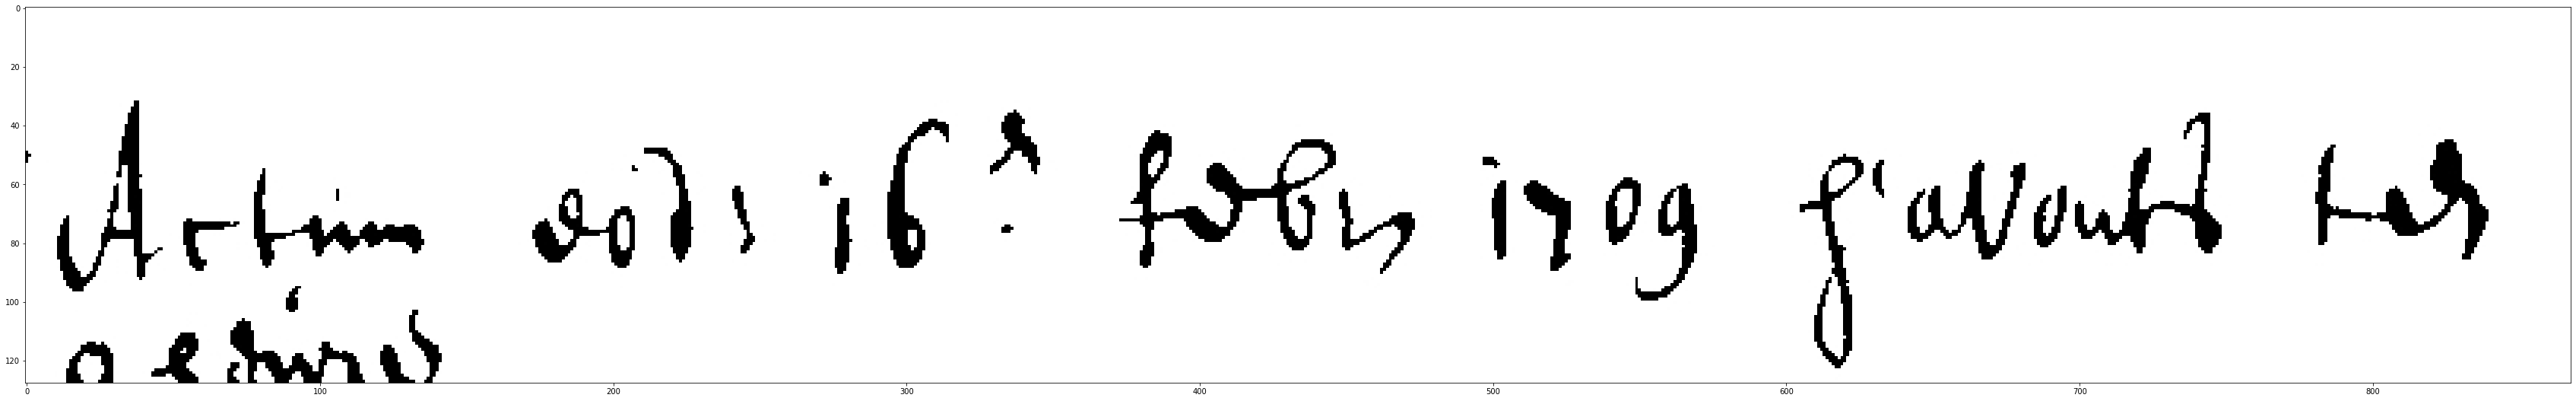

In [20]:
import cv2
from matplotlib import pyplot as plt
image = cv2.imread("/content/getuigenissen/imgs/textlines_su_h128/RABrugge_TBO119_693_088-01.jpg")
plt.figure(figsize = (60,30))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Below we show an example of the different textlines

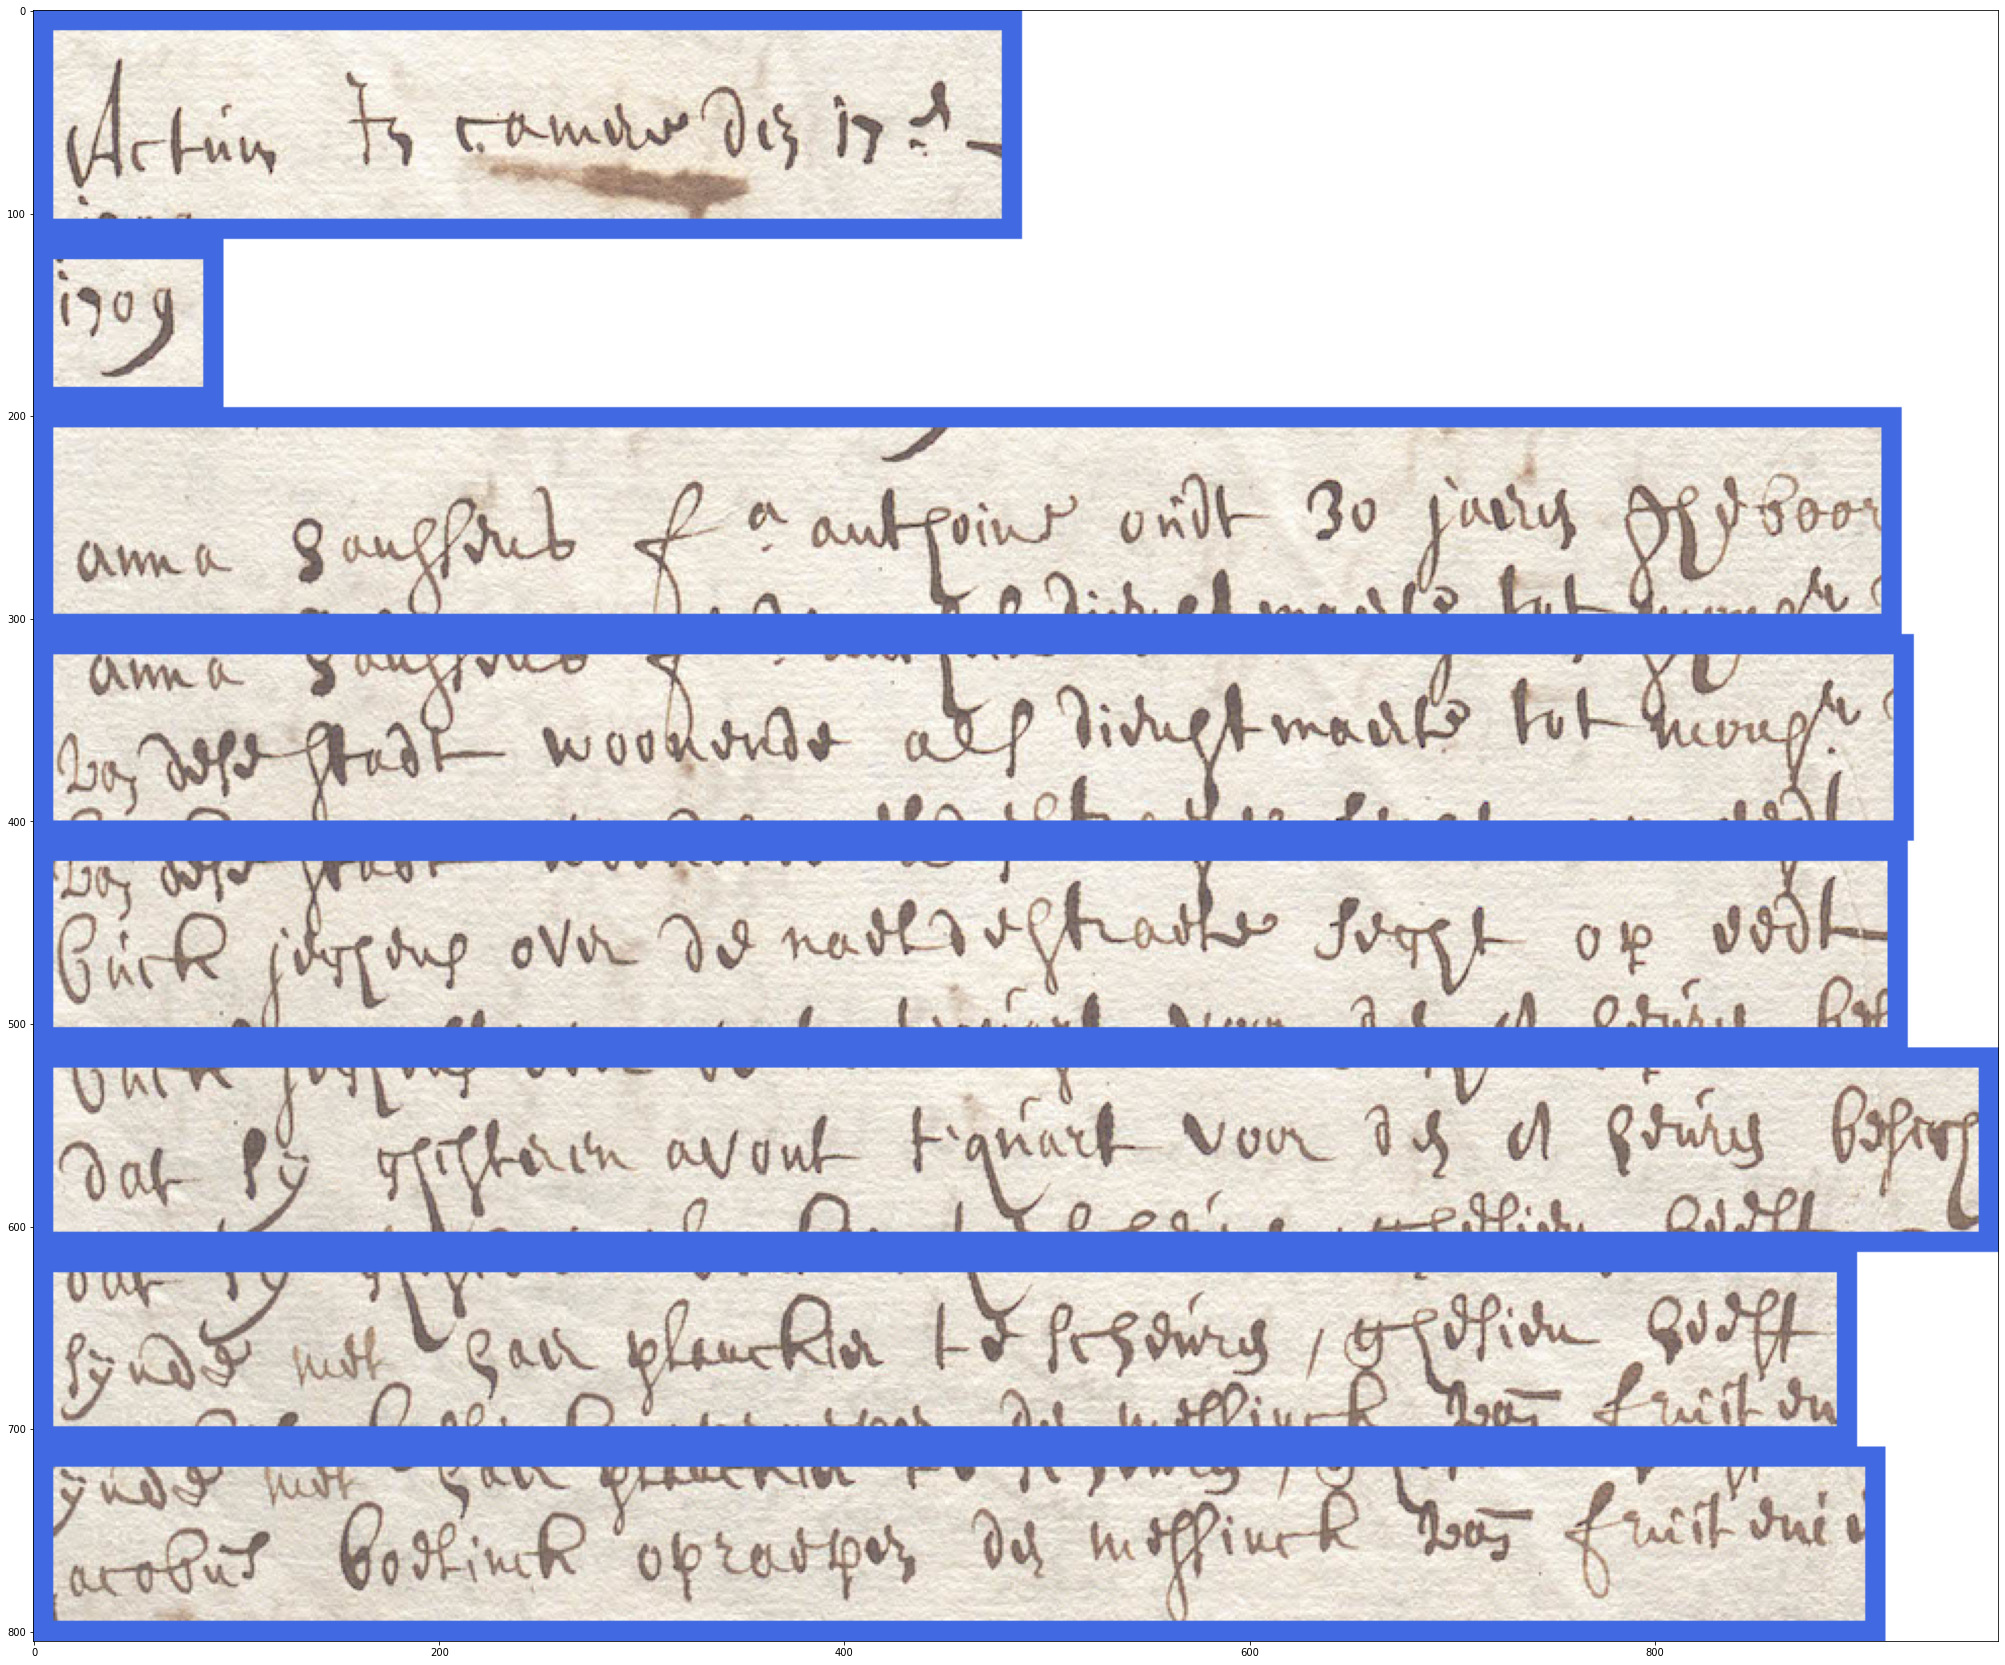

In [22]:
import cv2
from matplotlib import pyplot as plt
image = cv2.imread("/content/RABrugge_TBO119_693_088a.png")
plt.figure(figsize = (60,30))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

This is the list of allowed tokens for the model

In [24]:
!cat /content/getuigenissen/imgs/syms_ctc.txt

<ctc> 0
- 1
, 2
; 3
: 4
! 5
? 6
/ 7
. 8
' 9
" 10
( 11
) 12
@ 13
* 14
& 15
# 16
+ 17
0 18
1 19
2 20
3 21
4 22
5 23
6 24
7 25
8 26
9 27
a 28
A 29
b 30
B 31
c 32
C 33
d 34
D 35
e 36
E 37
f 38
F 39
g 40
G 41
h 42
H 43
i 44
I 45
j 46
J 47
k 48
K 49
l 50
L 51
m 52
M 53
n 54
N 55
o 56
O 57
p 58
P 59
q 60
Q 61
r 62
R 63
s 64
S 65
t 66
T 67
u 68
U 69
v 70
V 71
w 72
W 73
x 74
X 75
y 76
Y 77
z 78
Z 79


# Build the model

- CNN followed by Recursive layers (LSTM) and CTC
- Take default settings which are als used in the HTR model
- Number of channels in each input: 1

In [25]:
!which pylaia-htr-create-model
!python3.8 /usr/local/bin/pylaia-htr-create-model \
 1 "/content/getuigenissen/imgs/syms_ctc.txt" \
  --adaptive_pooling "avgpool-16" \
  --cnn_num_features 16 32 48 64 80 \
  --cnn_kernel_size 3 3 3 3 3 \
  --cnn_stride 1 1 1 1 1 \
  --cnn_dilation 1 1 1 1 1 \
  --cnn_activations LeakyReLU LeakyReLU LeakyReLU LeakyReLU LeakyReLU \
  --cnn_poolsize 2 2 2 0 0 \
  --cnn_dropout 0 0 0 0 0 \
  --cnn_batchnorm f f f f f \
  --rnn_units "256" \
  --rnn_layers "5" \
  --logging_file "/content/getuigenissen/log/trace.log" \
  --logging_also_to_stderr INFO \
  --train_path "/content/getuigenissen" \
  --seed "0x12345"

/usr/local/bin/pylaia-htr-create-model
2020-08-19 08:32:58,279 INFO laia.common.arguments : 
{'adaptive_pooling': 'avgpool-16',
 'cnn_activations': ['LeakyReLU',
                     'LeakyReLU',
                     'LeakyReLU',
                     'LeakyReLU',
                     'LeakyReLU'],
 'cnn_batchnorm': [False, False, False, False, False],
 'cnn_dilation': [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1)],
 'cnn_dropout': [0.0, 0.0, 0.0, 0.0, 0.0],
 'cnn_kernel_size': [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],
 'cnn_num_features': [16, 32, 48, 64, 80],
 'cnn_poolsize': [(2, 2), (2, 2), (2, 2), (0, 0), (0, 0)],
 'cnn_stride': [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1)],
 'fixed_input_height': None,
 'lin_dropout': 0.5,
 'logging_also_to_stderr': 20,
 'logging_config': None,
 'logging_file': '/content/getuigenissen/log/trace.log',
 'logging_level': 20,
 'logging_overwrite': False,
 'model_filename': 'model',
 'num_input_channels': 1,
 'print_args': True,
 'rnn_dropout': 0.5,
 'rnn_layers'

# Train the model on the training set of text lines


In [ ]:
!export CUDA_VISIBLE_DEVICES=1
!which pylaia-htr-train-ctc
!python3.8 /usr/local/bin/pylaia-htr-train-ctc \
  "/content/getuigenissen/imgs/syms_ctc.txt" \
  /content/getuigenissen/imgs/textlines_su_h128 \
  /content/getuigenissen/imgs/{tr,va}.txt \
  --add_logsoftmax_to_loss "true" \
  --batch_size "10" \
  --checkpoint "ckpt.lowest-valid-cer*" \
  --delimiters "@" \
  --gpu 1 \
  --learning_rate "0.0003" \
  --logging_also_to_stderr INFO \
  --logging_file "/content/getuigenissen/log/training-trace.log" \
  --max_nondecreasing_epochs "20" \
  --num_rolling_checkpoints "3" \
  --save_checkpoint_interval "10" \
  --show_progress_bar "true" \
  --train_path "/content/getuigenissen" \
  --use_baidu_ctc "false" \
  --use_distortions "false" \
  --seed "0x12345";

/usr/local/bin/pylaia-htr-train-ctc
2020-08-19 08:33:14,836 INFO laia.common.arguments : 
{'add_logsoftmax_to_loss': True,
 'batch_size': 10,
 'checkpoint': 'ckpt.lowest-valid-cer*',
 'delimiters': ['@'],
 'gpu': 1,
 'img_dirs': ['/content/getuigenissen/imgs/textlines_su_h128'],
 'iterations_per_update': 1,
 'learning_rate': 0.0003,
 'logging_also_to_stderr': 20,
 'logging_config': None,
 'logging_file': '/content/getuigenissen/log/training-trace.log',
 'logging_level': 20,
 'logging_overwrite': False,
 'max_epochs': None,
 'max_nondecreasing_epochs': 20,
 'model_filename': 'model',
 'momentum': 0,
 'num_rolling_checkpoints': 3,
 'print_args': True,
 'save_checkpoint_interval': 10,
 'seed': 74565,
 'show_progress_bar': True,
 'syms': <_io.TextIOWrapper name='/content/getuigenissen/imgs/syms_ctc.txt' mode='r' encoding='UTF-8'>,
 'tr_txt_table': <_io.TextIOWrapper name='/content/getuigenissen/imgs/tr.txt' mode='r' encoding='UTF-8'>,
 'train_path': '/content/getuigenissen',
 'train_sample

*Combine* everything in a zip file in order to locally inspect the results

In [ ]:
!pwd
!rm -r pylaia-run-htr
!rm pylaia-run-htr.tar.gz
!cp -R /content/getuigenissen pylaia-run-htr
!tar -zcf pylaia-run-htr.tar.gz pylaia-run-htr

/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls -l 
!cp pylaia-run-htr.tar.gz "/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 3525304
drwxr-xr-x   1 root root       4096 Jul 30 16:22 bin
drwxr-xr-x   2 root root       4096 Apr 24  2018 boot
drwxr-xr-x   1 root root       4096 Aug 13 09:15 content
drwxr-xr-x   1 root root       4096 Aug 10 21:57 datalab
drwxr-xr-x   5 root root        440 Aug 13 08:46 dev
drwxr-xr-x   1 root root       4096 Aug 13 09:16 etc
drwxr-xr-x   2 root root       4096 Apr 24  2018 home
drwxr-xr-x   6 root root       4096 Aug 13 09:16 imgtxtenh
drwxr-xr-x   1 root root       4096 Jul 30 16:24 lib
drwxr-xr-x   2 root root       4096 Jul 30 16:17 lib32
drwxr-xr-x   1 root root       4096 Jul 30 16:17 lib64
drwxr-xr-x   2 root root       4096 Oct 29  2019 media
drwxr-xr-x   2 root root       4096 Oct 29  2019 mnt
drwxr-xr-x   1 root root       4096 Aug 13 08:46 opt
dr-xr-xr-x 125 root root          0 Aug 13 08:46 proc
drwxr-xr-x   5 root root       4096 Aug

# See how we are doing on a holdout test image line

In [ ]:
!head -10 /content/getuigenissen/imgs/te.txt

32500569-10 R e u s b l o c k @ m e t @ d e n @ p e n s i o n a r i s
32500583-08 t w e e @ i o n g e r s @ w a e r @ o p @ d e n @ s o n e @ v a n d e n @ h u y s e
32500583-17 S c h a p e l i n c k @ d o o r @ d e n @ r e g h t e r @ h a n d t @ e n d e @ s l i n c k e r
32500591-06 g i s t e r e n @ n a e r @ d e n @ e e n @ h e u r e n @ s t a e n d e @ v o o r @ h e t @ h u u s
32500616-03 A u d e n a e r d e @ w o o n e n d e @ o p @ J e r u s a l e m @ p l a e t s e @ j e c h e n s @ o v e r @ d e @
32500616-10 s l o t , @ a l s @ h e t @ n a c h t s l o t @ n i e t @ t o e w e s e n d e , @ e n d e @ h e e f t
32500626-06 t o t @ J a q u e m y n k e n @ D e @ V o s @ h e e f t @ g h e s i e n @ o p @
32500626-14 s e g h t @ h e t @ s e l v e @ n i e t @ g h e s i e n @ t e @ h e b e n @ n o g h t e
32500629-03 M a r i e @ K o c l e @ f i l i a @ S t e v e n @ o u d t @ 2 0 @ j a e r e n @ g h e b o o r e n @ v a n @ T h i e l t
32500629-11 s e g g h e n d e @ a e n d e @ c l a 

In [ ]:
!head -10 /content/getuigenissen/imgs/test.txt

32500569-10
32500583-08
32500583-17


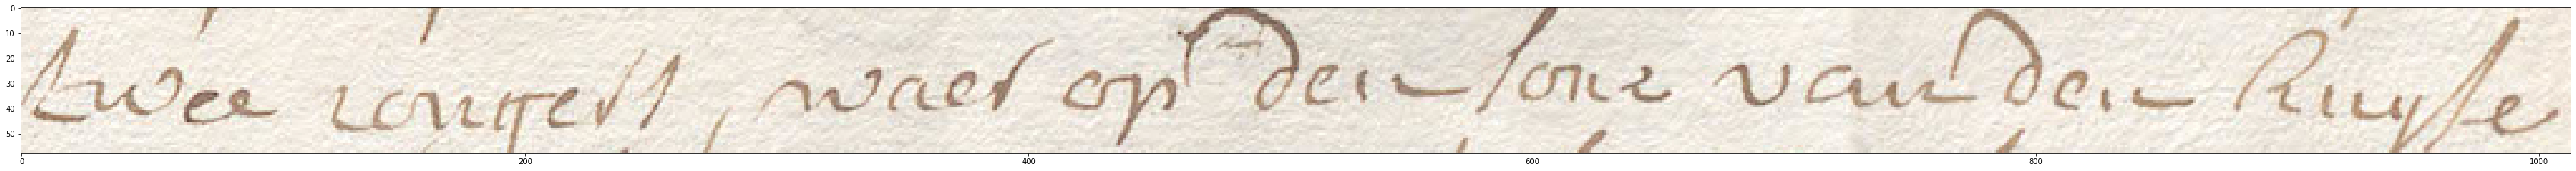

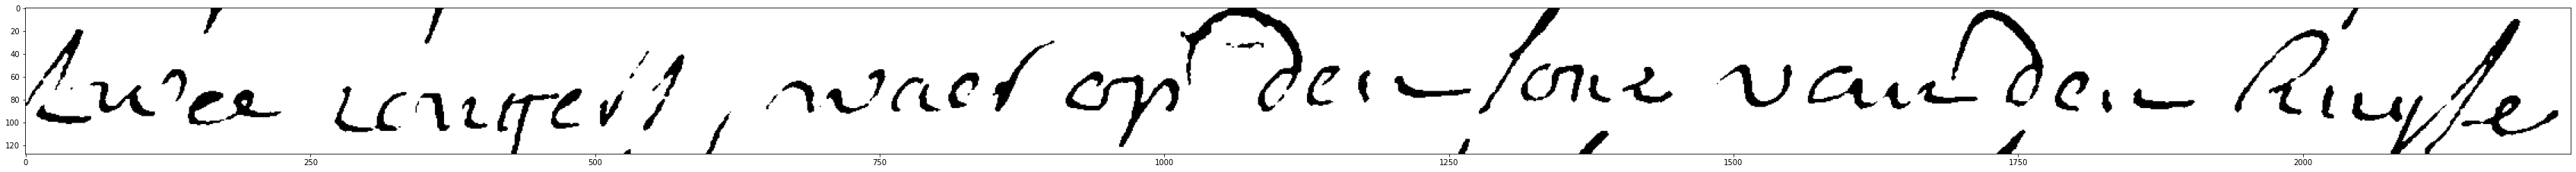

In [ ]:
import cv2
from matplotlib import pyplot as plt
image = cv2.imread("/content/getuigenissen/imgs/textlines/32500583-08.jpg")
plt.figure(figsize = (60,30))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
image = cv2.imread("/content/getuigenissen/imgs/textlines_su_h128/32500583-08.jpg")
plt.figure(figsize = (60,30))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
!which pylaia-htr-decode-ctc
!python3.8 /usr/local/bin/pylaia-htr-decode-ctc \
  "/content/getuigenissen/imgs/syms_ctc.txt" \
  "/content/getuigenissen/imgs/textlines_su_h128" \
  "/content/getuigenissen/imgs/test.txt" \
  --print_img_ids \
  --batch_size 1 \
  --join_str=" " \
  --use_letters \
  --train_path "/content/getuigenissen" \
  --gpu 1;

/usr/local/bin/pylaia-htr-decode-ctc
32500569-10 h e u r b l o c k @ m e t @ d e n @ p e n s i o n a r i s
32500583-08 t w e e @ j o n g e r s , @ w a e r @ o p @ d e n @ s o n e @ v a n @ d e n @ h u y s e
32500583-17 s c h a p e l i n c k @ d o o r @ d e n @ j e g h t e r @ s a n d t @ e n d e @ k n c k e r
